In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [9]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
        
    data_x_seq, data_y_seq = [], []
    for i in range(len(data_x)-timesteps):
        flag=1
        for iy in data_y[i:i+timesteps]:
    #         print(iy)
            if(iy[0]==0.5):
    #             print(0.5)
                flag=0
                break
        if(flag==1):  
            x=data_x[i:i+timesteps]
            y=data_y[i+timesteps]
            data_x_seq.append(x)
            data_y_seq.append(y)      
    
    return data_x_seq, data_y_seq

In [18]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'GD'])
    step_data_list.append([i, 1, '1L', 'WC'])
    step_data_list.append([i, 1, '2R', 'GD'])
    step_data_list.append([i, 1, '2R', 'WC'])
    step_data_list.append([i, 2, '1L', 'WC'])
    step_data_list.append([i, 2, '2R', 'WC'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [1, 1, '1L', 'WC'], [1, 1, '2R', 'GD'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [2, 1, '1L', 'GD'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'GD'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [3, 1, '1L', 'GD'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'GD'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [4, 1, '1L', 'GD'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'GD'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [5, 1, '1L', 'GD'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'GD'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'], [5, 2, '2R', 'WC']]


In [19]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    data_x.extend(data_x_segement)
    data_y.extend(data_y_segement)
    
print(len(data_x)) #93638
print(len(data_y))

92958
92958


In [22]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

92958


In [23]:
step_test_list = []
for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '1L', 'WC'])
    step_test_list.append([i, 1, '2R', 'GD'])
    step_test_list.append([i, 1, '2R', 'WC'])
    step_test_list.append([i, 2, '1L', 'WC'])
    step_test_list.append([i, 2, '2R', 'WC'])
    
print(step_test_list)

[[6, 1, '1L', 'GD'], [6, 1, '1L', 'WC'], [6, 1, '2R', 'GD'], [6, 1, '2R', 'WC'], [6, 2, '1L', 'WC'], [6, 2, '2R', 'WC']]


In [24]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
    
print(len(test_x))
print(len(test_y))

13894
13894


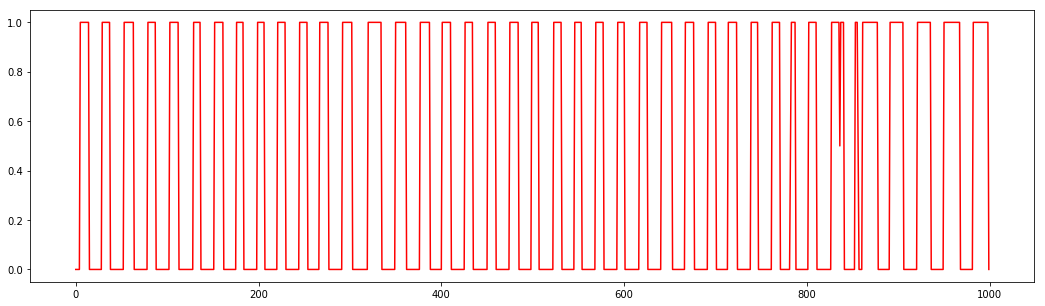

In [26]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1000:2000]], 'r')
plt.show()

In [27]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [ ]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        lstm_cell = rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
        cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
        cell = rnn.MultiRNNCell([cell] * 1)
#         cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [28]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

92958
92958


In [29]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

93214


In [30]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [74]:
training_steps = 201

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-9w.ckpt', global_step=step+15200)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-9w.ckpt-15000
Initialized
Loss at step 0: 0.021410, train accuarcy : 0.968750
Loss at step 200: 0.022961, train accuarcy : 0.953125


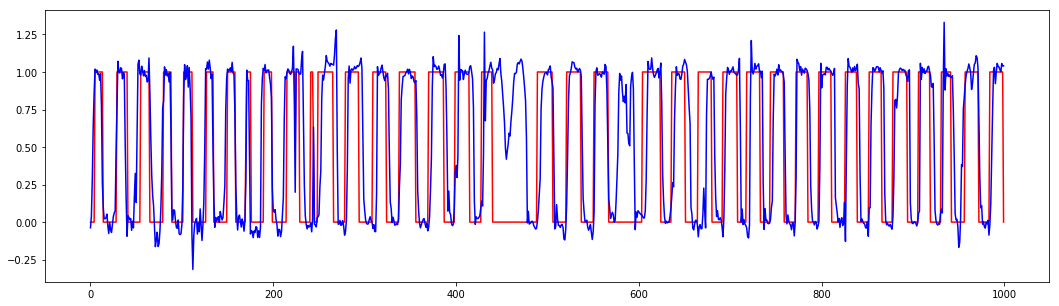

In [75]:
plt.figure(figsize=(18, 5))
start=6000
end=7000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [76]:
# print(test_y)
print(test_logits)

[[ 1.03731465]
 [ 1.04548573]
 [ 1.0154767 ]
 ..., 
 [ 0.91266668]
 [ 0.94114161]
 [ 0.95645225]]


In [77]:
print("test loss : ", test_loss)

test_logits_int = [[round(i[0])] for i in test_logits]

count = 0
for i in range(0, len(test_x)):
#     if(test_y[i][0] == round(test_logits[i][0])):
    if(test_y[i][0] == test_logits_int[i][0]):
        count += 1;
print(count)
print(len(test_x))
print("test accuarcy : ", count*1.0/len(test_x))

test loss :  0.113572
12015
13894
test accuarcy :  0.8647617676694976


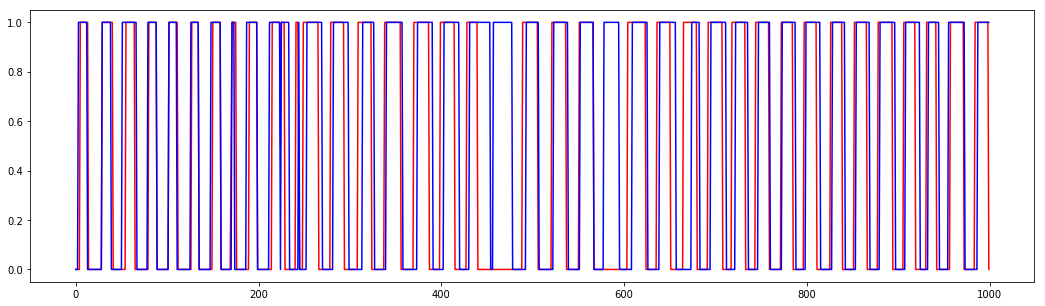

In [78]:
plt.figure(figsize=(18, 5))
start=6000
end=7000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits_int[start:end]], 'b')
plt.show()

In [79]:
#test_y      [[0], [0], [1]]
#test_logits 

step_time_actual = []
step_time_predict = []
for i in range(1, len(test_y)):
    if(abs(test_y[i][0]-test_y[i-1][0])>0.5):
        step_time_actual.append(i)
    if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
#     if(abs(test_logits_int[i][0]-test_logits_int[i-1][0])>0.5):
        step_time_predict.append(i)

print(len(step_time_actual))   
print(len(step_time_predict))

940
666


In [80]:
step_count = len(step_time_actual)
undercount = 0
overcount = 0

for i in range(1, step_count):
    gap_count = [t for t in step_time_predict if t>=step_time_actual[i-1] and t<step_time_actual[i]]
#     print(gap_count)
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1

print(undercount)
print(overcount)
print('undercount : ', undercount*1.0/step_count)
print('overcount : ', overcount*1.0/step_count)
print('segement undercount : ', 1-len(step_time_predict)*1.0/len(step_time_actual))

422
149
undercount :  0.44893617021276594
overcount :  0.15851063829787235
segement undercount :  0.2914893617021277
